In [ ]:
# +-------------------------------------------------------------------+
# |       Sieć neuronowa z jedną warstwą ukrytą neuronów (ReLU)       |
# |                Uczenie metodą SGD z momentum.                     |
# +-------------------------------------------------------------------+

# 1000 neuronów - chyba przewymiarowanie

import numpy as np
import matplotlib.pyplot as plt

In [6]:

# Funkcja do aproksymacji
Fun = lambda x: np.sin(2 * x[0, :] + x[1, :]) / np.exp(0.2 * x[1, :])

n_inputs = 2 # liczba wejść
n_hidden = 1000 # liczba neuronów ukrytych
n_outputs = 1 # liczba wyjść

n_train = 9000 # liczba próbek uczących
n_val = 3000   # liczba próbek walidujących

# Generowanie próbek uczących i walidujących
X_min = 0; X_max = 10

X_train = np.random.uniform(X_min, X_max, (n_inputs, n_train))
Y_train = Fun(X_train)
X_train = (X_train - X_min) / (X_max - X_min)  # Przeskalowanie do [0, 1]

X_val = np.random.uniform(X_min, X_max, (n_inputs, n_val))
Y_val = Fun(X_val)
X_val = (X_val - X_min) / (X_max - X_min)  # Przeskalowanie do [0, 1]

In [ ]:

# Wczytaj zapisane wagi modelu oraz poprzednie kierunki minimalizacji

data = np.load(f"weights_({n_hidden})_hidden.npz")

b1 = data['b1']
W1 = data['W1']
b2 = data['b2']
W2 = data['W2']

p_b1_old = data['p_b1_old']
p_W1_old = data['p_W1_old']
p_b2_old = data['p_b2_old']
p_W2_old = data['p_W2_old']

# ----------------------------------------------

# # Losowa inicjalizacja wag i biasów

# b1 = np.random.uniform(-1, 1, (n_hidden, 1))
# W1 = np.random.uniform(-1, 1, (n_hidden, n_inputs))

# b2 = np.random.uniform(-1, 1, (n_outputs, 1))
# W2 = np.random.uniform(-1, 1, (n_outputs, n_hidden))

# # zerowa inicjalizacja poprzedniego kierunku minimalizacji

# p_b1_old = np.zeros((n_hidden, 1))
# p_W1_old = np.zeros((n_hidden, n_inputs))

# p_b2_old = np.zeros((n_outputs, 1))
# p_W2_old = np.zeros((n_outputs, n_hidden))

Epoka [10/10]  MSE train: 1.077675e-04  MSE val: 1.035203e-04

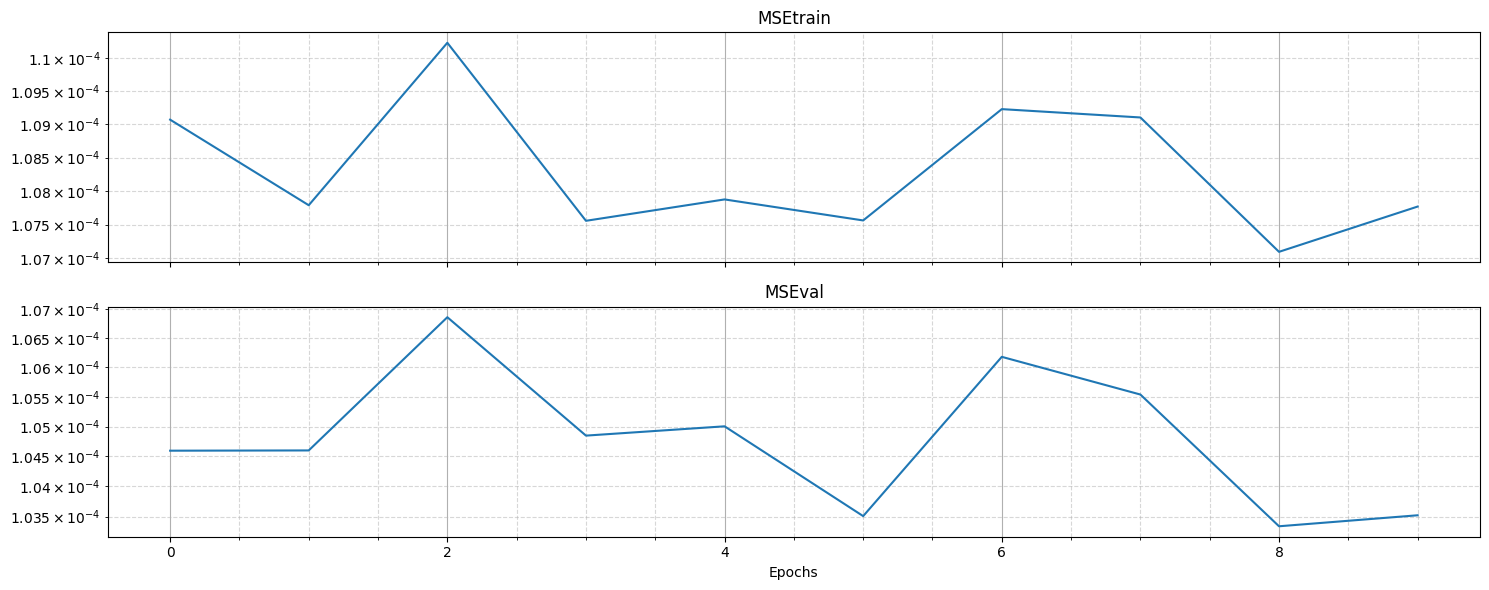

In [37]:

max_epochs = 10 # maksymalna liczba epok
learning_rate = 0.01 # współczynnik uczenia
momentum = 0.9 # współczynnik momentum
mb_size = 500 # rozmiar mini-batcha


# deklaracja potrzebnych tablic

idx = np.zeros((1, mb_size), dtype=int)
X = np.zeros((n_inputs, mb_size))
Y = np.zeros((n_outputs, mb_size))

# ---

Z1 = np.zeros((n_hidden, mb_size))
V1 = np.zeros((n_hidden, mb_size))

Z2 = np.zeros((n_outputs, mb_size))
Y_hat = np.zeros((n_outputs, mb_size))

# ---

p_b1 = np.zeros((n_hidden, 1))
p_W1 = np.zeros((n_hidden, n_inputs))

p_b2 = np.zeros((n_outputs, 1))
p_W2 = np.zeros((n_outputs, n_hidden))

# ---

dL2 = np.zeros((n_outputs, mb_size))
dL1 = np.zeros((n_hidden, mb_size))

# ---

dE_db1 = np.zeros((n_hidden, 1))
dE_dW1 = np.zeros((n_hidden, n_inputs))

dE_db2 = np.zeros((n_outputs, 1))
dE_dW2 = np.zeros((n_outputs, n_hidden))

# ---

MSEtrainTab = np.zeros((max_epochs, 1))
MSEvalTab = np.zeros((max_epochs, 1))


# uczenie sieci metodą SGD+momentum

for i in range(max_epochs):
    for j in range(1000):
        idx = np.random.permutation(n_train)[:mb_size]
        X = X_train[:, idx]
        Y = Y_train[idx]

        # Forward pass
        Z1 = W1 @ X + b1
        V1 = np.maximum(0, Z1)
        Z2 = W2 @ V1 + b2
        Y_hat = Z2

        # Backward pass
        dL2 = 2 * (Y_hat - Y)
        dL1 = (W2.T @ dL2) * (Z1 > 0)

        # Gradienty
        dE_db2 = np.mean(dL2, axis=1, keepdims=True)
        dE_dW2 = (dL2 @ V1.T) / mb_size

        dE_db1 = np.mean(dL1, axis=1, keepdims=True)
        dE_dW1 = (dL1 @ X.T) / mb_size

        # Aktualizacja kierunków
        p_b2 = (1 - momentum) * dE_db2 + momentum * p_b2_old
        p_W2 = (1 - momentum) * dE_dW2 + momentum * p_W2_old
        p_b1 = (1 - momentum) * dE_db1 + momentum * p_b1_old
        p_W1 = (1 - momentum) * dE_dW1 + momentum * p_W1_old

        # Aktualizacja wag i biasów
        b2 -= learning_rate * p_b2
        W2 -= learning_rate * p_W2
        b1 -= learning_rate * p_b1
        W1 -= learning_rate * p_W1

        # Zapisanie poprzednich kierunków
        p_b2_old = p_b2
        p_W2_old = p_W2
        p_b1_old = p_b1
        p_W1_old = p_W1

    MSEtrain = np.mean((b2 + W2 @ np.maximum(0, W1 @ X_train + b1) - Y_train) ** 2)
    MSEval = np.mean((b2 + W2 @ np.maximum(0, W1 @ X_val + b1) - Y_val) ** 2)

    MSEtrainTab[i] = MSEtrain
    MSEvalTab[i] = MSEval

    print(f"\rEpoka [{i+1}/{max_epochs}]  MSE train: {MSEtrain:.6e}  MSE val: {MSEval:.6e}", end='')


# Wyświetlanie przebiegu uczenia

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

ax1.plot(MSEtrainTab)
ax1.set_yscale('log')
ax1.set_title("MSEtrain")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.plot(MSEvalTab)
ax2.set_yscale('log')
ax2.set_title("MSEval")
ax2.set_xlabel("Epochs")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

plt.tight_layout() # ładniej wyglądają wykresy

In [38]:
# Zapisanie wyznaczonych wag modelu
np.savez(f"weights_({n_hidden})_hidden.npz", 
    b1=b1, W1=W1, b2=b2, W2=W2,
    p_b1_old=p_b1_old, p_W1_old=p_W1_old, p_b2_old=p_b2_old, p_W2_old=p_W2_old)


 MSE train:  1.077675e-04
 MSE val:    1.035203e-04

 AbsErr train:  6.246411e-03
 AbsErr val:    6.667052e-03


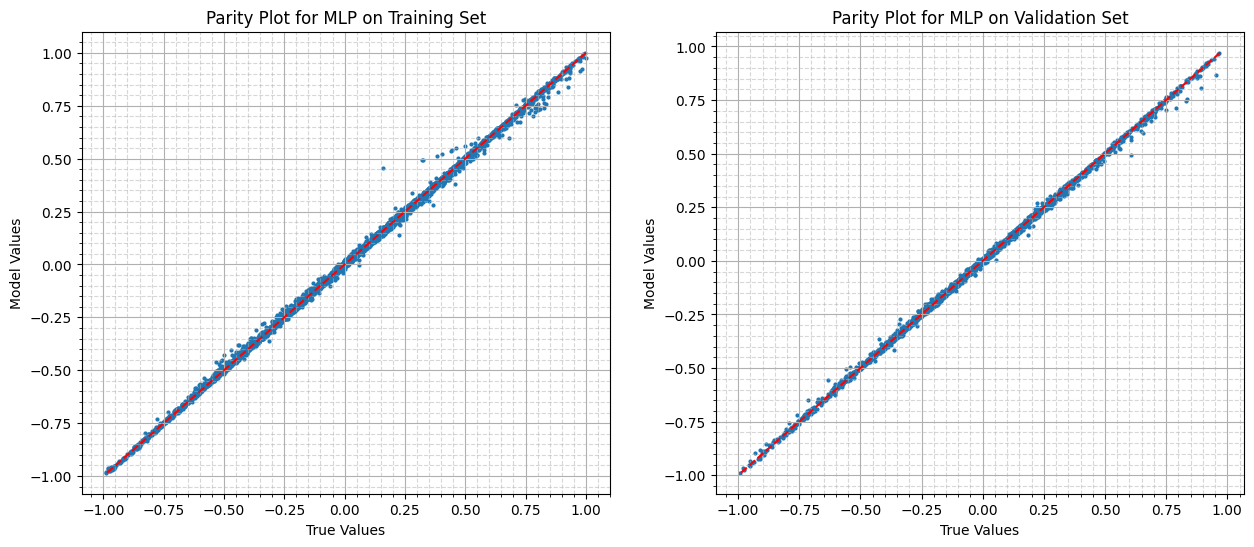

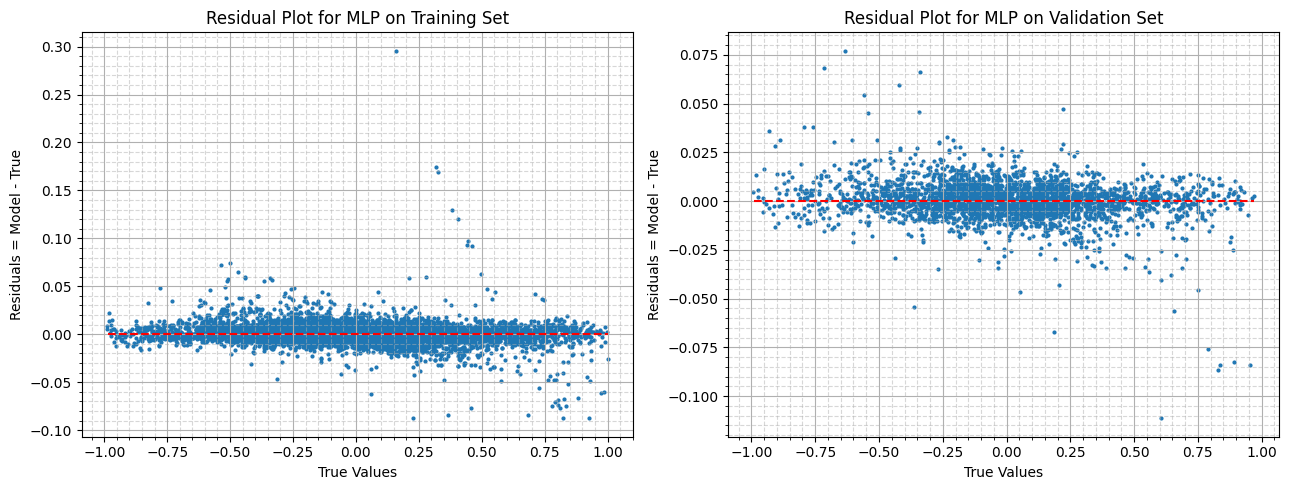

In [39]:
# --- Ocena modelu przed douczeniem ---

Ymodel_train = W2 @ np.maximum(0, W1 @ X_train + b1) + b2
Ymodel_val = W2 @ np.maximum(0, W1 @ X_val + b1) + b2

MSEtrain = np.mean((Ymodel_train - Y_train) ** 2)
MSEval = np.mean((Ymodel_val - Y_val) ** 2)
print(f"\n MSE train:  {MSEtrain:.6e}\n MSE val:    {MSEval:.6e}")

ERRtrain = np.mean(np.abs(Ymodel_train - Y_train))
ERRval = np.mean(np.abs(Ymodel_val - Y_val))
print(f"\n AbsErr train:  {ERRtrain:.6e}\n AbsErr val:    {ERRval:.6e}")

#  --- Wykres dopasowania (prawdziwy Y) vs (przewidywany Y) ---

Ymodel_train_min = np.min(Ymodel_train)
Ymodel_train_max = np.max(Ymodel_train)
Ymodel_val_min = np.min(Ymodel_val)
Ymodel_val_max = np.max(Ymodel_val)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(Y_train, Ymodel_train, s=4)
ax1.plot([Ymodel_train_min, Ymodel_train_max], [Ymodel_train_min, Ymodel_train_max], 'r--')
ax1.set_title("Parity Plot for MLP on Training Set")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Model Values")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.scatter(Y_val, Ymodel_val, s=4)
ax2.plot([Ymodel_val_min, Ymodel_val_max], [Ymodel_val_min, Ymodel_val_max], 'r--')
ax2.set_title("Parity Plot for MLP on Validation Set")
ax2.set_xlabel("True Values")
ax2.set_ylabel("Model Values")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

# --- Wykres residual plot ---

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.scatter(Y_train, Ymodel_train - Y_train, s=4)
ax1.plot([Ymodel_train_min, Ymodel_train_max], [0,0], 'r--')
ax1.set_title("Residual Plot for MLP on Training Set")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Residuals = Model - True")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.scatter(Y_val, Ymodel_val - Y_val, s=4)
ax2.plot([Ymodel_val_min, Ymodel_val_max], [0,0], 'r--')
ax2.set_title("Residual Plot for MLP on Validation Set")
ax2.set_xlabel("True Values")
ax2.set_ylabel("Residuals = Model - True")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

plt.tight_layout() # ładniej wyglądają wykresy


 MSE train:  6.477486e-05
 MSE val:    8.029863e-05

 AbsErr train:  5.290911e-03
 AbsErr val:    5.866330e-03


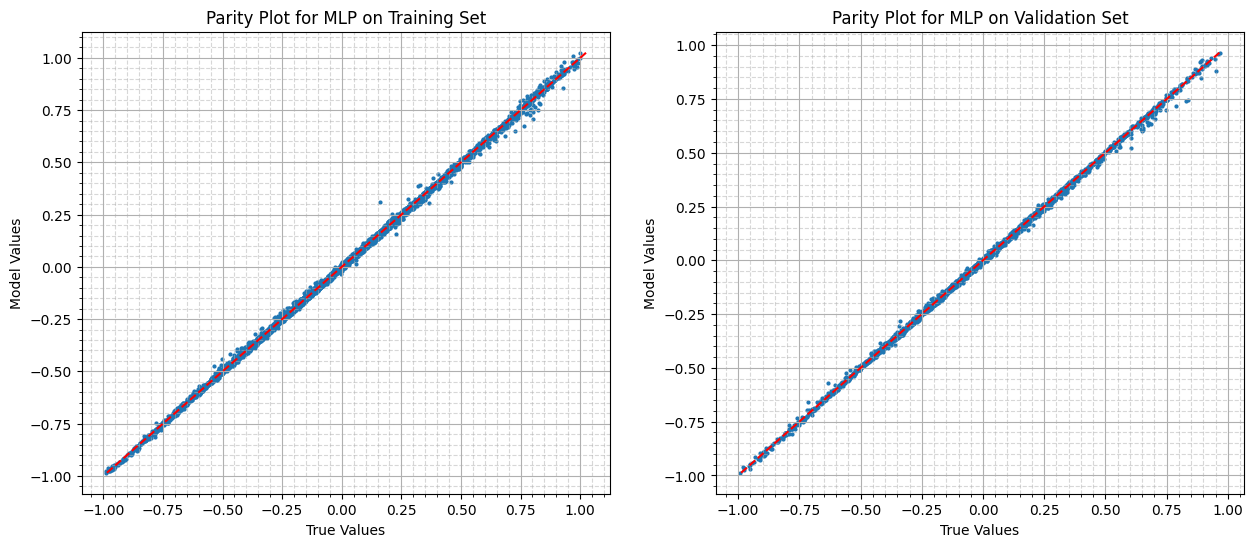

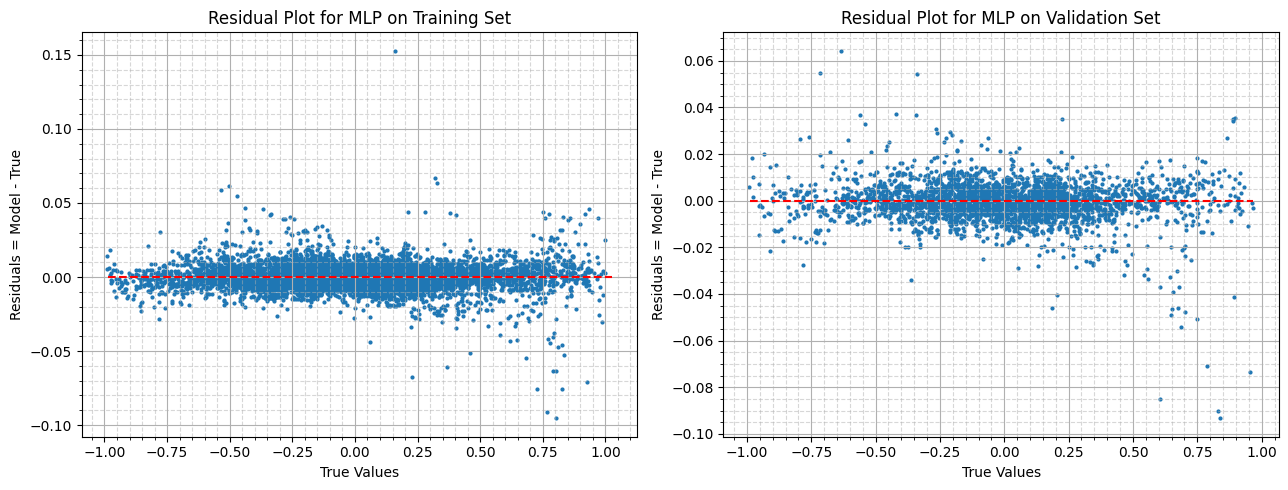

In [40]:
# --- Douczenie wag drugiej warstwy metodą ELM ---

lambda_reg = 0.0001  # współczynnik regularizacji

A = np.hstack(( np.ones((n_train, 1)), np.maximum(0, b1 + W1 @ X_train).T ))
W = np.linalg.solve(A.T @ A + lambda_reg * np.eye(n_hidden + 1), A.T @ Y_train)

b2_ = W[0]
W2_ = W[1:].reshape(1, n_hidden)


# --- Ocena modelu po douczeniu ---

Ymodel_train = W2_ @ np.maximum(0, W1 @ X_train + b1) + b2_
Ymodel_val = W2_ @ np.maximum(0, W1 @ X_val + b1) + b2_

MSEtrain = np.mean((Ymodel_train - Y_train) ** 2)
MSEval = np.mean((Ymodel_val - Y_val) ** 2)
print(f"\n MSE train:  {MSEtrain:.6e}\n MSE val:    {MSEval:.6e}")

ERRtrain = np.mean(np.abs(Ymodel_train - Y_train))
ERRval = np.mean(np.abs(Ymodel_val - Y_val))
print(f"\n AbsErr train:  {ERRtrain:.6e}\n AbsErr val:    {ERRval:.6e}")


#  --- Wykres dopasowania (prawdziwy Y) vs (przewidywany Y) ---

Ymodel_train_min = np.min(Ymodel_train)
Ymodel_train_max = np.max(Ymodel_train)
Ymodel_val_min = np.min(Ymodel_val)
Ymodel_val_max = np.max(Ymodel_val)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(Y_train, Ymodel_train, s=4)
ax1.plot([Ymodel_train_min, Ymodel_train_max], [Ymodel_train_min, Ymodel_train_max], 'r--')
ax1.set_title("Parity Plot for MLP on Training Set")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Model Values")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.scatter(Y_val, Ymodel_val, s=4)
ax2.plot([Ymodel_val_min, Ymodel_val_max], [Ymodel_val_min, Ymodel_val_max], 'r--')
ax2.set_title("Parity Plot for MLP on Validation Set")
ax2.set_xlabel("True Values")
ax2.set_ylabel("Model Values")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

# --- Wykres residual plot ---

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.scatter(Y_train, Ymodel_train - Y_train, s=4)
ax1.plot([Ymodel_train_min, Ymodel_train_max], [0,0], 'r--')
ax1.set_title("Residual Plot for MLP on Training Set")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Residuals = Model - True")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.scatter(Y_val, Ymodel_val - Y_val, s=4)
ax2.plot([Ymodel_val_min, Ymodel_val_max], [0,0], 'r--')
ax2.set_title("Residual Plot for MLP on Validation Set")
ax2.set_xlabel("True Values")
ax2.set_ylabel("Residuals = Model - True")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

plt.tight_layout() # ładniej wyglądają wykresy